In [1]:
import numpy as np


def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """
    # if iter % lr_decay_iter or iter > max_iter:
    # 	return optimizer

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    return lr
    # return lr


def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)


In [2]:
import torch
from torchvision import models


class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]

In [3]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple


class CityScapes(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        super(CityScapes, self).__init__()
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.images_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.images = []
        self.labels = []

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            lbl_dir = os.path.join(self.labels_dir, city)

            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(img_dir, file_name)
                    lbl_path = os.path.join(lbl_dir, file_name.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png'))

                    if not os.path.exists(img_path):
                        print(f"Image file does not exist: {img_path}")
                    if not os.path.exists(lbl_path):
                        print(f"Label file does not exist: {lbl_path}")

                    self.images.append(img_path)
                    self.labels.append(lbl_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        label = Image.open(lbl_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_class_names(self):
        return ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
                'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
                'motorcycle', 'bicycle']


In [5]:
import torch.fft

def apply_fda(source_img, target_img, beta=0.01):
    source_fft = torch.fft.fftshift(torch.fft.fftn(source_img, dim=(-2, -1)))
    target_fft = torch.fft.fftshift(torch.fft.fftn(target_img, dim=(-2, -1)))

    _, _, h, w = source_fft.size()

    b = int(min(h, w) * beta)
    source_fft[:, :, h//2-b:h//2+b, w//2-b:w//2+b] = target_fft[:, :, h//2-b:h//2+b, w//2-b:w//2+b]

    source_ifft = torch.real(torch.fft.ifftn(torch.fft.ifftshift(source_fft), dim=(-2, -1)))

    return source_ifft


In [12]:
import os
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms

class GTA5(Dataset):
    def __init__(self, root_dir, cityscapes_root_dir, transform=None, target_transform=None):
        super(GTA5, self).__init__()
        self.root_dir = root_dir
        self.cityscapes_root_dir = cityscapes_root_dir
        self.transform = transform
        self.target_transform = target_transform

        self.images_dir = os.path.join(self.root_dir, 'images')
        self.labels_dir = os.path.join(self.root_dir, 'labels')
        self.cityscapes_images_dir = os.path.join(self.cityscapes_root_dir, 'leftImg8bit', 'train')

        self.images = []
        self.labels = []
        self.cityscapes_images = []

        for image in os.listdir(self.images_dir):
            image_path = os.path.join(self.images_dir, image)
            label_path = os.path.join(self.labels_dir, image)
            if os.path.exists(label_path):
                self.images.append(image_path)
                self.labels.append(label_path)

        for city in os.listdir(self.cityscapes_images_dir):
            city_dir = os.path.join(self.cityscapes_images_dir, city)
            for file_name in os.listdir(city_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    self.cityscapes_images.append(os.path.join(city_dir, file_name))

        # Map from color to corresponding class of Cityscapes
        self.color_to_id = {
            (128, 64, 128): 0,   # road
            (244, 35, 232): 1,   # sidewalk
            (70, 70, 70): 2,     # building
            (102, 102, 156): 3,  # wall
            (190, 153, 153): 4,  # fence
            (153, 153, 153): 5,  # pole
            (250, 170, 30): 6,   # light
            (220, 220, 0): 7,    # sign
            (107, 142, 35): 8,   # vegetation
            (152, 251, 152): 9,  # terrain
            (70, 130, 180): 10,  # sky
            (220, 20, 60): 11,   # person
            (255, 0, 0): 12,     # rider
            (0, 0, 142): 13,     # car
            (0, 0, 70): 14,      # truck
            (0, 60, 100): 15,    # bus
            (0, 80, 100): 16,    # train
            (0, 0, 230): 17,     # motorcycle
            (119, 11, 32): 18    # bicycle
        }

    def __getitem__(self, idx):
        try:
            source_img = Image.open(self.images[idx]).convert('RGB')
            label = Image.open(self.labels[idx]).convert('RGB')

            # Load a random target image
            target_idx = random.randint(0, len(self.cityscapes_images) - 1)
            target_img = Image.open(self.cityscapes_images[target_idx]).convert('RGB')

            if self.transform is not None:
                source_img = self.transform(source_img)
                target_img = self.transform(target_img)
                label = self.target_transform(label)
                label = self.map_color_to_class(label)

            # Apply FDA
            source_img = apply_fda(source_img.unsqueeze(0), target_img.unsqueeze(0)).squeeze(0)

        except (UnidentifiedImageError, FileNotFoundError) as e:
            print(f"Error loading image {self.images[idx]} or label {self.labels[idx]}, skipping...")
            return self.__getitem__((idx + 1) % len(self.images))

        return source_img, label

    def __len__(self):
        return len(self.images)

    def map_color_to_class(self, label):
        # Convert the RGB image to a single integer value
        label_int = label[:, :, 0] * 256 * 256 + label[:, :, 1] * 256 + label[:, :, 2]

        # Create a tensor of the same shape as the input image, filled with 255 (the class for 'unlabeled')
        class_id_image = torch.full_like(label_int, 255)

        # Replace each unique color value with the corresponding class
        for color, class_id in self.color_to_id.items():
            color_int = color[0] * 256 * 256 + color[1] * 256 + color[2]
            class_id_image = torch.where(label_int == color_int, class_id, class_id_image)

        return class_id_image


In [13]:
from torchvision import transforms
import random

resize_transform = transforms.Resize((720, 1280))

# Augmentation Set 1
augmentations_1 = transforms.Compose([
    resize_transform,
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

gta5_target_transform = transforms.Compose([
    transforms.Resize((720, 1280), interpolation=Image.NEAREST),
    transforms.Lambda(lambda lbl: torch.tensor(np.array(lbl), dtype=torch.long)),
])

cityscapes_transform = transforms.Compose([
    transforms.Resize((512,1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cityscapes_target_transform = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.NEAREST),
    transforms.Lambda(lambda lbl: torch.tensor(np.array(lbl), dtype=torch.long)),
])


In [14]:
from torchvision import transforms
from torch.utils.data import DataLoader

gta5_root = '/content/drive/MyDrive/MLDLMLDL/GTA5'
cityscapes_root = '/content/drive/MyDrive/MLDLMLDL/Cityscapes/Cityscapes/Cityspaces'

# Dataset and DataLoader with FDA
gta5_dataset_fda = GTA5(gta5_root, cityscapes_root, transform=augmentations_1, target_transform=gta5_target_transform)
gta5_loader_fda = DataLoader(gta5_dataset_fda, batch_size=8, shuffle=True, num_workers=12)


cityscapes_dataset = CityScapes(root_dir=cityscapes_root, split='val', transform=cityscapes_transform, target_transform=cityscapes_target_transform)
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=8, shuffle=False, num_workers=12)


In [15]:
print(len(gta5_dataset_fda))
print(len(cityscapes_dataset))

2500
500


In [16]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiSeNet(num_classes=19, context_path='resnet18').to(device)

# Hyperparameters
num_epochs = 50
learning_rate = 2e-2
batch_size = 4
num_classes = 19
# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

class_names = cityscapes_dataset.get_class_names()

In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Initialize variables to store training losses, validation losses, training mIoUs, and validation mIoUs for Aug. 1
train_losses_aug1 = []
val_losses_aug1 = []
train_mIoUs_aug1 = []
val_mIoUs_aug1 = []

# Using Aug. 1 loader
gta5_loader = gta5_loader_fda
aug_type = 'Aug. 1'
best_mIoU = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    hist_train = np.zeros((num_classes, num_classes))
    for iter, (images, labels) in enumerate(gta5_loader):
        images = images.to(device)
        labels = labels.to(device).long()

        # Forward pass
        optimizer.zero_grad()
        outputs, _, _ = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update learning rate
        current_iter = epoch * len(gta5_loader) + iter
        poly_lr_scheduler(optimizer, learning_rate, current_iter, max_iter=num_epochs * len(gta5_loader))

        running_loss += loss.item()

        # Calculate training mIoU
        preds_train = torch.argmax(outputs, dim=1)
        hist_train += fast_hist(labels.cpu().numpy().flatten(), preds_train.cpu().numpy().flatten(), num_classes)

        if (iter + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{iter+1}/{len(gta5_loader)}], Loss: {loss.item():.4f}')

    avg_train_loss = running_loss / len(gta5_loader)
    train_losses_aug1.append(avg_train_loss)
    train_mIoUs_epoch = per_class_iou(hist_train)
    avg_train_mIoU = np.mean(train_mIoUs_epoch)
    train_mIoUs_aug1.append(avg_train_mIoU)
    print(f'Epoch [{epoch+1}/{num_epochs}], {aug_type} Training Loss: {avg_train_loss:.4f}, Train Mean mIoU: {avg_train_mIoU:.4f}')

    # Validation
    model.eval()
    hist_val = np.zeros((num_classes, num_classes))
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in cityscapes_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            preds_val = torch.argmax(outputs, dim=1)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            hist_val += fast_hist(labels.cpu().numpy().flatten(), preds_val.cpu().numpy().flatten(), num_classes)

    avg_val_loss = running_val_loss / len(cityscapes_loader)
    val_losses_aug1.append(avg_val_loss)
    val_mIoUs_epoch = per_class_iou(hist_val)
    avg_val_mIoU = np.mean(val_mIoUs_epoch)
    val_mIoUs_aug1.append(avg_val_mIoU)
    print(f'Epoch [{epoch+1}/{num_epochs}], {aug_type} Validation Loss: {avg_val_loss:.4f}, Val Mean mIoU: {avg_val_mIoU:.4f}')
    for i, iou in enumerate(val_mIoUs_epoch):
        print(f'{class_names[i]}: Val mIoU = {iou:.4f}')

    # Save the model if it has the best mIoU so far
    if avg_val_mIoU > best_mIoU:
        best_mIoU = avg_val_mIoU
        torch.save(model.state_dict(), f'/content/drive/MyDrive/MLDLMLDL/best_model_FDA_{aug_type.replace(" ", "_")}.pth')
        print(f'Model saved with Mean mIoU: {avg_val_mIoU:.4f}')

    # Clear cache to free up memory
    torch.cuda.empty_cache()


Epoch [1/50], Step [10/313], Loss: 1.1157
Epoch [1/50], Step [20/313], Loss: 0.8127
Epoch [1/50], Step [30/313], Loss: 0.8819
Epoch [1/50], Step [40/313], Loss: 0.6533
Epoch [1/50], Step [50/313], Loss: 0.5593
Epoch [1/50], Step [60/313], Loss: 0.4353
Epoch [1/50], Step [70/313], Loss: 0.5014
Epoch [1/50], Step [80/313], Loss: 0.5082
Epoch [1/50], Step [90/313], Loss: 0.4991
Epoch [1/50], Step [100/313], Loss: 0.3835
Epoch [1/50], Step [110/313], Loss: 0.4267
Epoch [1/50], Step [120/313], Loss: 0.3853
Epoch [1/50], Step [130/313], Loss: 0.4313
Error loading image /content/drive/MyDrive/MLDLMLDL/GTA5/images/00417.png or label /content/drive/MyDrive/MLDLMLDL/GTA5/labels/00417.png, skipping...
Epoch [1/50], Step [140/313], Loss: 0.4086
Epoch [1/50], Step [150/313], Loss: 0.5125
Epoch [1/50], Step [160/313], Loss: 0.3906
Epoch [1/50], Step [170/313], Loss: 0.4038
Epoch [1/50], Step [180/313], Loss: 0.3257
Epoch [1/50], Step [190/313], Loss: 0.6008
Epoch [1/50], Step [200/313], Loss: 0.4261

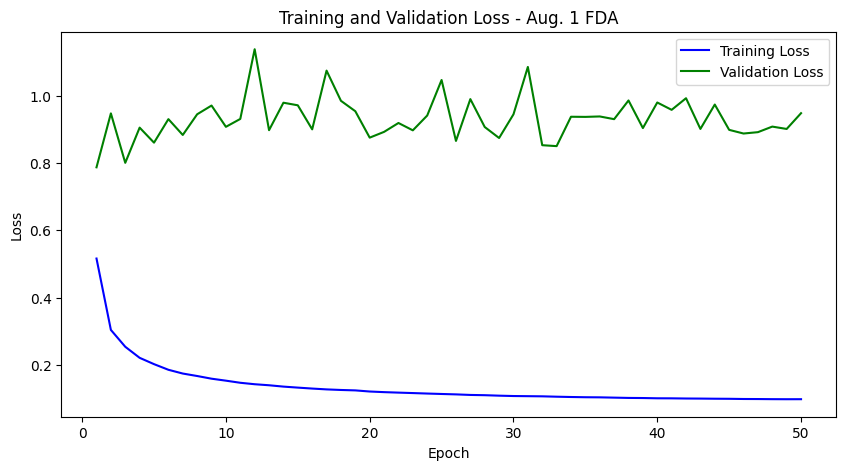

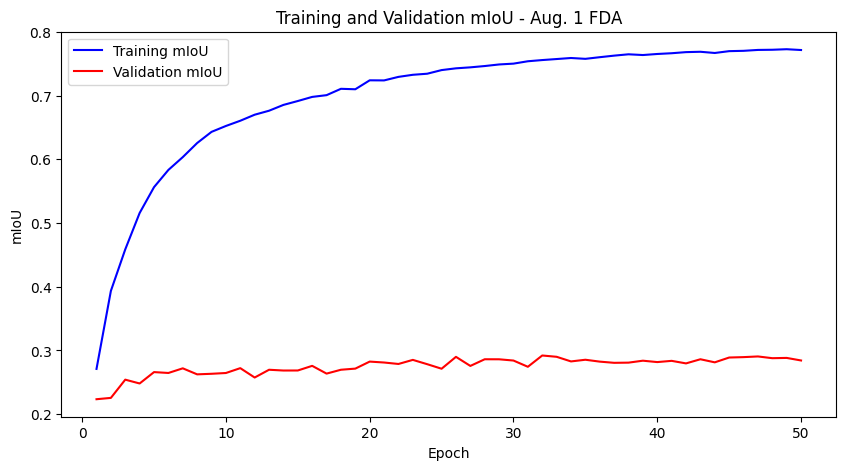

In [19]:
import matplotlib.pyplot as plt

# Define the range of epochs
epochs = range(1, num_epochs + 1)

# Plot for Training and Validation Loss for Aug. 1
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses_aug1, 'b-', label='Training Loss')
plt.plot(epochs, val_losses_aug1, 'g-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Aug. 1 FDA')
plt.legend()
plt.show()

# Plot for Training and Validation mIoU for Aug. 1
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_mIoUs_aug1, 'b-', label='Training mIoU')
plt.plot(epochs, val_mIoUs_aug1, 'r-', label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU - Aug. 1 FDA')
plt.legend()
plt.show()
